# INF8225 TP1 H25 (v2.0)

**Mohamed Ali ** - LAJNEF/ Matricule 2409535

Partie 3 réalisée:
ou avec
[Mathis - NGUYEN -
Matricule 2409535]

Date limite :

20h30 le 6 février 2025 (Partie 1 et 2)

20h30 le 20 février 2025 (Partie 3)

Remettez votre fichier Colab sur Moodle en 2 formats: **.pdf** ET **.ipynb**

**Comment utiliser**:

Il faut copier ce notebook dans vos dossiers pour avoir une version que vous pouvez modifier, voici deux façons de le faire:
* File / Save a copy in Drive ...
* File / Download .ipynb

**Pour utiliser un GPU**

Runtime / Change Runtime Type / Hardware Accelerator / GPU

## Fonctions fournies

In [4]:
# fonctions pour charger les ensembles de donnees
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=1):
  dataset = FashionMNIST("./dataset", train=True,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  dataset_test = FashionMNIST("./dataset", train=False,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  len_train = int(len(dataset) * (1.-val_percentage))
  len_val = len(dataset) - len_train
  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
  data_loader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True,num_workers=4)
  data_loader_val   = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=4)
  data_loader_test  = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=4)
  return data_loader_train, data_loader_val, data_loader_test

def reshape_input(x, y):
    x = x.view(-1, 784)
    y = torch.FloatTensor(len(y), 10).zero_().scatter_(1,y.view(-1,1),1)
    return x, y


# call this once first to download the datasets
_ = get_fashion_mnist_dataloaders()

In [5]:
# simple logger to track progress during training
class Logger:
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accuracies_train = []
        self.accuracies_valid = []

    def log(self, accuracy_train=0, loss_train=0, accuracy_valid=0, loss_valid=0):
        self.losses_train.append(loss_train)
        self.accuracies_train.append(accuracy_train)
        self.losses_valid.append(loss_valid)
        self.accuracies_valid.append(accuracy_valid)

    def plot_loss_and_accuracy(self, train=True, valid=True):

        assert train and valid, "Cannot plot accuracy because neither train nor valid."

        figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                            figsize=(12, 6))

        if train:
            ax1.plot(self.losses_train, label="Training")
            ax2.plot(self.accuracies_train, label="Training")
        if valid:
            ax1.plot(self.losses_valid, label="Validation")
            ax1.set_title("CrossEntropy Loss")
            ax2.plot(self.accuracies_valid, label="Validation")
            ax2.set_title("Accuracy")

        for ax in figure.axes:
            ax.set_xlabel("Epoch")
            ax.legend(loc='best')
            ax.set_axisbelow(True)
            ax.minorticks_on()
            ax.grid(True, which="major", linestyle='-')
            ax.grid(True, which="minor", linestyle='--', color='lightgrey', alpha=.4)

    def print_last(self):
        print(f"Epoch {len(self.losses_train):2d}, \
                Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, \
                Valid: loss={self.losses_valid[-1]:.3f}, accuracy={self.losses_valid[-1]*100:.1f}%", flush=True)

## Aperçu de l'ensemble de données FashionMnist

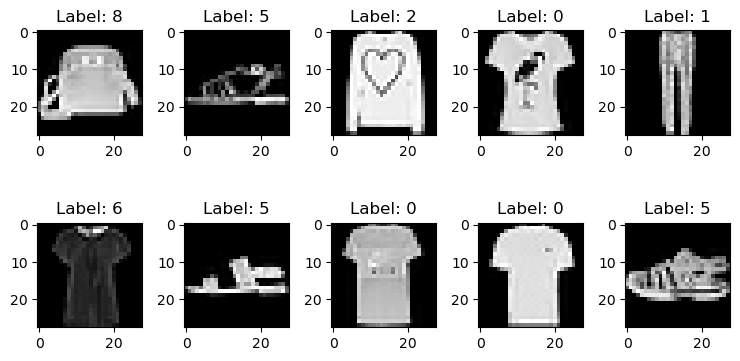

In [3]:
def plot_samples():
  a, _, _ = get_fashion_mnist_dataloaders()
  num_row = 2
  num_col = 5# plot images
  num_images = num_row * num_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i, (x,y) in enumerate(a):
      if i >= num_images:
        break
      ax = axes[i//num_col, i%num_col]
      x = (x.numpy().squeeze() * 255).astype(int)
      y = y.numpy()[0]
      ax.imshow(x, cmap='gray')
      ax.set_title(f"Label: {y}")

  plt.tight_layout()
  plt.show()
plot_samples()

# Partie 3 (20 points)

Pour cette partie, vous pouvez travailler en groupes de 2, mais il faut écrire sa propre dérivation et soumettre son propre rapport. Si vous travaillez avec un partenaire, il faut indiquer leur nom dans votre rapport.

### Problème

![picture](https://drive.google.com/uc?id=17_N7pIrf5pypQKiUh5cM7SX6raZUBcJC)

Considérons maintenant un réseau de neurones avec une couche d'entrée avec $D=784$ unités, $L$ couches cachées, chacune avec 300 unités et un vecteur de sortie $\mathbf{y}$ de dimension $K$. Vous avez $i = 1, .., N$ exemples dans un ensemble d'apprentissage, où chaque ${\bf x}_i \in \mathbb{R}^{784}$ est un vecteur de caractéristiques (features). $\mathbf{y}$ est un vecteur du type *one-hot* -- un vecteur de zéros avec un seul 1 pour indiquer que la classe $C=k$ dans la dimension $k$. Par exemple, le vecteur $\mathbf{y}=[0, 1, 0, \cdots, 0]^T$ représente la deuxième classe. La fonction de perte est donnée par
\begin{equation}
\mathscr{L} = -\sum_{i=1}^{N}\sum_{k=1}^{K}y_{k,i}\log (f_k( {\bf x}_i )  )
\end{equation}

La fonction d'activation de la couche finale a la forme  ${\bf f} = [f_1, ..., f_K]$ donné par la fonction d'activation softmax:
\begin{equation}
f_k( {\bf a}^{(L+1)}({\bf x}_i) ) = \frac{\exp(a_k^{(L+1)})}{\sum_{c=1}^{K}\exp(a_c^{(L+1)})}, \;\;\;\;
\nonumber
\end{equation}

et les couches cachées utilisent une fonction d'activation de type ReLU:
\begin{equation}
  {\bf h}^{(l)}({\bf a}^{(l)}({\bf x}_i)) = \text{ReLU}({\bf a}^{(l)}({\bf x}_i) = \max\Big(0, \, \, {\bf a}^{(l)}({\bf x}_i)\Big)
\end{equation}

où ${\bf a}^{(l)}$ est le vecteur résultant du calcul de la préactivation habituelle ${\bf a}^{(l)}={\bf W}^{(l)}{\bf h}^{(l-1)} + {\bf b}^{(l)}$, qui pourrait être simplifiée à ${\boldsymbol \theta}^{(l)}\tilde{\bf h}^{(l-1)}$ en utilisant l'astuce de définir $\tilde{\bf h}$ comme ${\bf h}$ avec un 1 concaténé à la fin du vecteur.



### Questions

* a) (10 points) Donnez le pseudocode incluant des *calculs matriciels—vectoriels* détaillés pour l'algorithme de rétropropagation pour calculer le gradient pour les paramètres de chaque couche **étant donné un exemple d'entraînement**.

* b) (15 points)
Implémentez l'optimisation basée sur le gradient de ce réseau en Pytorch.
Utilisez le code squelette ci-dessous comme point de départ et implémentez les mathématiques de l'algorithme de rétropropagation que vous avez décrit à la question précédente. Comparez vos gradients et votre optimisation avec le même modèle optimisé avec Autograd. Lequel est le plus rapide ? Proposez quelques expériences. Utilisez encore l'ensemble de données de Fashion MNIST (voir Partie 2). **Comparez différents modèles ayant différentes largeurs (nombre d'unités) et profondeurs (nombre de couches)**. Ici encore, n'utilisez l'ensemble de test que pour votre expérience finale lorsque vous pensez avoir obtenu votre meilleur modèle.


**IMPORTANT**

L'objectif du TP est de vous faire implémenter la rétropropagation à la main. L'objectif est d'implémenter un modèle de classification logistique ainsi que son entainement en utilisant uniquement des opérations matricielles de base fournies par PyTorch e.g. torch.sum(), torch.matmul(), etc. **Une fois que vous avez implémenté votre modèle, vous devez le comparer avec un modèle construit en utilisant les capacités de pytorch qui permettent une différenciation automatique. Autrement dit, pour la deuxième implémentation, vous pouvez utilisertorch.nn, torch.autograd ou à la méthode .backward().** Vous pouvez utiliser l’implémentation de votre choix pour explorer différentes architectures de modèles.

## Votre pseudocode:

# Modèle de Réseau de Neurones Général à n Couches

Soit les transformations suivantes dans un réseau de neurones avec \( n \) couches cachées :

## 1. Propagation Avant

### **Entrée** :
$$
\mathbf{x} = \text{input}
$$

### **Transformation Linéaire et Activation à Chaque Couche**

Pour chaque couche cachée l allant de 1 à n : 

1. **Préactivation** :
     $$
     \mathbf{a}^{(1)} = \boldsymbol{\theta}^{(1)} \mathbf{x}
     $$
   - Pour $( l > 1 )$ :
     $$
     \mathbf{a}^{(l)} = \boldsymbol{\theta}^{(l)} \tilde{\mathbf{h}}^{(l-1)}
     $$
2. **Activation ReLU** :
   $$
   \mathbf{h}^{(l)} = \text{ReLU}'(\mathbf{a}^{(l)})
   $$

où :

 $\tilde{\mathbf{h}}^{(l-1)}$ est le vecteur $\mathbf{h}^{(l-1)}$ auquel on ajoute une composante égale à 1 à la fin pour inclure le biais.


### **Dernière Couche (Sortie)**

1. **Transformation linéaire finale** :
   $$
   \mathbf{a}^{(n+1)} = \boldsymbol{\theta}^{(n+1)} \tilde{\mathbf{h}}^{(n)}

   $$
2. **Sortie avec softmax** :
   $$
   \mathbf{h}^{(n+1)} = \hat{y} = \text{softmax}(\mathbf{a}^{(n+1)})
   $$

### **Fonction de Coût (Cross-Entropy)**

La fonction de coût est définie comme :
$$
J = CE(y, \hat{y})
$$

## 2. Calcul du Gradient pour la Rétropropagation

Nous savons d'après le cours que  :
$$
\frac{\partial J}{\partial \mathbf{a}^{(n+1)}} = \hat{y} - y
$$

Ensuite, en appliquant la règle de la chaîne, nous avons :
$$
\frac{\partial J}{\partial \boldsymbol{\theta}^{(n+1)}} = \left( \frac{\partial J}{\partial \mathbf{a}^{(n+1)}} \right) \cdot \left( \frac{\partial \mathbf{a}^{(n+1)}}{\partial \boldsymbol{\theta}^{(n+1)}} \right)
$$

$$
\frac{\partial J}{\partial \boldsymbol{\theta}^{(n+1)}} = (\hat{y} - y) \cdot  \tilde{\mathbf{h}}^{(n)}
$$

De même,  pour $ l \neq 1 $ on a : 
$$
\frac{\partial J}{\partial \boldsymbol{\theta}^{(l)}} = 
\left( \frac{\partial J}{\partial \mathbf{a}^{(n+1)}} \right) \cdot  
\left( \frac{\partial \mathbf{a}^{(n+1)}}{\partial \mathbf{h}^{(n)}} \right) \cdot 
\left( \frac{\partial \mathbf{h}^{(n)}}{\partial \mathbf{a}^{(n)}} \right) \cdot 
\left( \frac{\partial \mathbf{a}^{(n)}}{\partial \mathbf{h}^{(n-1)}} \right) \cdot  
\left( \frac{\partial \mathbf{h}^{(n-1)}}{\partial \mathbf{a}^{(n-1)}} \right) \cdot ... \cdot 
\left( \frac{\partial \mathbf{a}^{(l)}}{\partial \boldsymbol{\theta}^{(l)}} \right)
$$

$$
\frac{\partial J}{\partial \boldsymbol{\theta}^{(l)}} = (\hat{y} - y) 
\cdot \left(  W^{(n+1)} \odot \text{ReLU}'(\mathbf{a}^{(n)}) \right) 
\cdot \left( W^{(n)} \odot \text{ReLU}'(\mathbf{a}^{(n-1)})  \right) 
\cdot ... \cdot
\tilde{\mathbf{h}}^{(n)}
$$

$$
\frac{\partial J}{\partial \boldsymbol{\theta}^{(l)}} = (\hat{y} - y) 
\cdot \prod_{k=l}^{n} \left( W^{(k+1)} \odot \text{ReLU}'(\mathbf{a}^{(k)}) \right) 
\cdot \tilde{\mathbf{h}}^{(l-1)}
$$




Nous introduisons alors un paramètre intermédiaire, appelé **delta**, défini entre 1 et $l+1$ comme :
$$
\delta^{(n+1)} = \frac{\partial J}{\partial \mathbf{a}^{(n+1)}} = \hat{y} - y
$$

$$
\delta^{(l)} = \delta^{(l+1)}  \cdot \left( W^{(l+1)} \odot \text{ReLU}'(\mathbf{a}^{(l)}) \right) 
$$


Ainsi, nous avons alors pour chaque couche  :
$$
\nabla \boldsymbol{\theta}^{(l)} = \mathbf{h}^{(l)T} \cdot \delta^{(l+1)}
$$

Seule la dernière couche diffère. En effet, on a : 
$$
\nabla \boldsymbol{\theta}^{(1)} = \mathbf{x}^{T} \cdot \delta^{(1)}
$$

## Fonctions à compléter

In [ ]:
''' Les fonctions dans cette cellule peuvent avoir les mêmes déclarations que celles de la partie 2'''
def accuracy(y, y_pred) :
    # todo : nombre d'éléments à classifier.
    card_D = torch.tensor(y.size(0), dtype=torch.float32)

    # todo : calcul du nombre d'éléments bien classifiés.

    # Find labels based on highest probability
    true_labels = torch.argmax(y, dim=1) # e.g [0, 1, 0] -> 1
    predicted_labels = torch.argmax(y_pred, dim=1) # e.g [0.1, 0.8, 0.1] -> 1
    # Compute number of right prediction
    card_C = torch.sum(true_labels == predicted_labels).float()

    # todo : calcul de la précision de classification.
    acc = card_C / card_D

    return acc, (card_C, card_D)

def accuracy_and_loss_whole_dataset(data_loader, model):
    cardinal = 0
    loss     = 0.
    n_accurate_preds  = 0.

    for x, y in data_loader:
        x, y = reshape_input(x, y)
        y_pred                = model.forward(x)
        xentrp                = cross_entropy(y, y_pred)
        _, (n_acc, n_samples) = accuracy(y, y_pred)

        cardinal = cardinal + n_samples
        loss     = loss + xentrp
        n_accurate_preds  = n_accurate_preds + n_acc

    loss = loss / float(cardinal)
    acc  = n_accurate_preds / float(cardinal)

    return acc, loss

def inputs_tilde(x, axis=-1):
    # augments the inputs `x` with ones along `axis`
    ones = torch.ones(x.size(0), 1) # create ones column
    x_tilde = torch.cat((x, ones), dim=axis)   # augments x along the axis (last)
    return x_tilde

def softmax(x, axis=-1):
    # assurez vous que la fonction est numeriquement stable
    # e.g. softmax(torch.tensor([[1000, 10000, 100000]]))

    # Modifying X for stability
    x_max = torch.max(x, dim=axis, keepdim=True).values
    x_stable = x - x_max

    # Softmax Function
    exp_x = torch.exp(x_stable) # Term to term exponential for x (batch_size, num_classes)
    sum_exp_x = torch.sum(exp_x, dim=axis, keepdim=True) # Scalar sum along each row (batch_size, 1)
    values = exp_x / sum_exp_x # Softmax result (batch_size, num_classes)

    return values

def cross_entropy(y, y_pred):
    # Cross Entropy Loss

    # Avoid Nan Problems
    epsilon = 1e-12
    y_pred_clipped = torch.clamp(y_pred, min=epsilon, max=1.0)
    loss = -torch.sum(y * torch.log(y_pred_clipped))
    return loss


def softmax_cross_entropy_backward(y, y_pred):
     # todo : calcul de la valeur du gradient de l'entropie croisée composée avec `softmax`
     values = y_pred - y
     return values

def relu_forward(x):
    # todo : calcul des valeurs de relu(x)
    values = torch.max(torch.zeros_like(x), x)
    return values

def relu_backward(x):
    # todo : calcul des valeurs du gradient de la fonction `relu`
    values = (x > 0).float()
    return values

# Fonction utilitaire pour initialiser les poids avec la "Xavier initialization" (une distribution normale ne permet pas de converger)
import numpy as np
def xavier_init(fan_in, fan_out):
    bound = np.sqrt(6.0 / (fan_in + fan_out))
    return torch.empty(fan_in, fan_out).uniform_(-bound, bound)



# Model est une classe representant votre reseaux de neuronnes
class MLPModel:
    def __init__(self, n_features, n_hidden_features, n_hidden_layers, n_classes):
        self.n_features        = n_features
        self.n_hidden_features = n_hidden_features
        self.n_hidden_layers   = n_hidden_layers
        self.n_classes         = n_classes

        # todo : initialiser la liste des paramètres Teta de l'estimateur.
        self.params = []

        # Matrice de poids de la couche d'entrée
        W0 = xavier_init(n_features + 1, n_hidden_features)
        self.params.append(W0)

        # Matrices de poids des couches cachées
        for _ in range(1, n_hidden_layers):
            WI = xavier_init(n_hidden_features + 1, n_hidden_features)
            self.params.append(WI)

        # Matrice de poids de la couche de sortie
        WL = xavier_init(n_hidden_features + 1, n_classes)
        self.params.append(WL)

        # print(f"Teta params={[p.shape for p in self.params]}")

        self.a = [] # liste contenant le resultat des multiplications matricielles
        self.h = [] # liste contenant le resultat des fonctions d'activations

        self.m_t = [torch.zeros_like(param) for param in self.params]  # pour Adam: moyennes mobiles du gradient
        self.v_t = [torch.zeros_like(param) for param in self.params]  # pour Adam: moyennes mobiles du carré du gradient
        self.t = 0

    def forward(self, x):
        self.a = []  # Réinitialise les pré-activations
        self.h = []  # Réinitialise les activations

        h = inputs_tilde(x)
        self.h.append(h)

        # Stockage des activations pour chaque matrice de poids dans les couches cachées
        for W in self.params[:-1]:
            a = torch.matmul(h, W)  # a = Wih+b = hWi
            self.a.append(a)

            h = relu_forward(a)     # ReLU
            h = inputs_tilde(h)     # ajout du biais pour appliquer la simplification
            self.h.append(h)

        # Stockage des activations pour la matrice de poids de la dernière couche
        a = torch.matmul(h, self.params[-1]) # a = WLh+b = hWL
        self.a.append(a)

        outputs = softmax(a)  # Softmax
        return outputs  # Retourne les probabilités pour chaque classe (batch_size, n_classes)


    def backward(self, y, y_pred):
        # todo : implémenter calcul des gradients.

        # Calcul des gradients
        grads = [None] * len(self.params)  # Liste pour stocker les gradients (pour chaque matrice de poids et biais)

        # Erreur de la couche de sortie
        delta = softmax_cross_entropy_backward(y, y_pred)  # delta^(L) = h^(L) - y


        # Gradient pour la couche de sortie
        grads[-1] = torch.matmul(self.h[-1].T, delta)  # grads^(L-1) = h^(L-1).T * delta^(L)

        # Backpropagation pour les couches cachées

        for i in range(len(self.params) - 2, -1, -1):  # Part de l'avant-dernière couche et remonte vers la première couche

            # Erreur de la couche courante
            delta = torch.matmul(delta, self.params[i + 1][:-1, :].T)  # delta^(l) = delta^(l+1) * W^(l+1).T
            delta *= relu_backward(self.a[i])  # delta^(l) *= ReLU'(a^(l))

            # Gradient de la couche courante
            grads[i] = torch.matmul(self.h[i].T, delta)  # grads^(l) = h^(l-1).T * delta^(l)

        return grads



    def sgd_update(self, lr, grads):
        for i in range(len(self.params)):
            self.params[i] -= lr * grads[i]  # Mise à jour des poids W^(l)

    def adam_update(self, lr, grads):
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        self.t += 1

        for i in range(len(self.params)):
            # Mise à jour des moyennes mobiles des gradients
            self.m_t[i] = beta1 * self.m_t[i] + (1 - beta1) * grads[i]
            self.v_t[i] = beta2 * self.v_t[i] + (1 - beta2) * (grads[i] ** 2)

            # Correction du biais
            m_t_hat = self.m_t[i] / (1 - beta1 ** self.t)
            v_t_hat = self.v_t[i] / (1 - beta2 ** self.t)
            # Mise à jour des poids
            self.params[i] -= lr * m_t_hat / (torch.sqrt(v_t_hat) + epsilon)


def train(model, lr=0.1, nb_epochs=10, sgd=True, data_loader_train=None, data_loader_val=None):
    best_model = None
    best_val_accuracy = 0
    logger = Logger()

    for epoch in range(nb_epochs+1):

        # at epoch 0 evaluate random initial model
        #   then for subsequent epochs, do optimize before evaluation.
        if epoch > 0:
            for x, y in data_loader_train:
                x, y = reshape_input(x, y)

                y_pred = model.forward(x)
                grads  = model.backward(y, y_pred)
                if sgd:
                  model.sgd_update(lr, grads)
                else:
                  model.adam_update(lr, grads)

        accuracy_train, loss_train = accuracy_and_loss_whole_dataset(data_loader_train, model)
        accuracy_val, loss_val = accuracy_and_loss_whole_dataset(data_loader_val, model)

        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_model = model

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        print(f"Epoch {epoch:2d}, \
                Train:loss={loss_train.item():.3f}, accuracy={accuracy_train.item()*100:.1f}%, \
                Valid: loss={loss_val.item():.3f}, accuracy={accuracy_val.item()*100:.1f}%", flush=True)

    return best_model, best_val_accuracy, logger

## Évaluation

### SGD: Recherche d'hyperparamètres

In [ ]:
# SGD
# Montrez les résultats pour différents nombre de couche, e.g. 1, 3, 5, et différent nombres de neurone, e.g. 25, 100, 300, 500, 1000.
depth_list = [1,3,5]                  # Define ranges in a list
width_list = [25,100,300,500,1000]    # Define ranges in a list
lr = 0.001                            # Some value
batch_size = 20                       # Some value

with torch.no_grad():
  for depth in depth_list:
    for width in width_list:
      print("------------------------------------------------------------------")
      print("Training model with a depth of {0} layers and a width of {1} units".format(depth, width))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

      MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
      _, val_accuracy, _ = train(MLP_model,lr=lr, nb_epochs=5, sgd=True, data_loader_train=data_loader_train, data_loader_val=data_loader_val)
      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 25 units
Epoch  0,                 Train:loss=2.521, accuracy=4.8%,                 Valid: loss=2.526, accuracy=4.4%
Epoch  1,                 Train:loss=0.515, accuracy=82.6%,                 Valid: loss=0.512, accuracy=82.7%
Epoch  2,                 Train:loss=0.435, accuracy=84.9%,                 Valid: loss=0.439, accuracy=84.8%
Epoch  3,                 Train:loss=0.408, accuracy=85.6%,                 Valid: loss=0.413, accuracy=85.6%
Epoch  4,                 Train:loss=0.409, accuracy=85.4%,                 Valid: loss=0.421, accuracy=84.6%
Epoch  5,                 Train:loss=0.383, accuracy=86.5%,                 Valid: loss=0.393, accuracy=86.1%
validation accuracy = 86.133
------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 100 units
Epoch  0,                 Train:loss=2.590, accura

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux nombre de couche et les colonnes correspondent au nombre de neurone dans chaque couche. Les valeurs ci-dessous sont donné comme exemples; remplacez-les par les valeurs que vous avez utilisées pour votre recherche d'hyperparamètres.

depth\width  | 25 | 100 | 300 | 500 | 1000
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 86.133  | 87.250 | 86.483 | 87.550 | 87.233 |
**3** | 84.450  | 87.500 | 88.467 | 87.733 | 88.850 |
**5**  | 85.850  | 87.617 | 88.133 | 88.450 | 87.283 |

### SGD: Analyse du meilleur modèle

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  0,                 Train:loss=2.317, accuracy=5.4%,                 Valid: loss=2.317, accuracy=5.4%
Epoch  1,                 Train:loss=0.417, accuracy=85.2%,                 Valid: loss=0.427, accuracy=84.8%
Epoch  2,                 Train:loss=0.364, accuracy=86.4%,                 Valid: loss=0.380, accuracy=85.9%
Epoch  3,                 Train:loss=0.333, accuracy=87.6%,                 Valid: loss=0.353, accuracy=86.7%
Epoch  4,                 Train:loss=0.289, accuracy=89.4%,                 Valid: loss=0.321, accuracy=88.3%
Epoch  5,                 Train:loss=0.295, accuracy=88.9%,                 Valid: loss=0.333, accuracy=87.9%
Best validation accuracy = 88.333
Evaluation of the best training model over test set
------
Loss : 0.365
Accuracy : 86.270


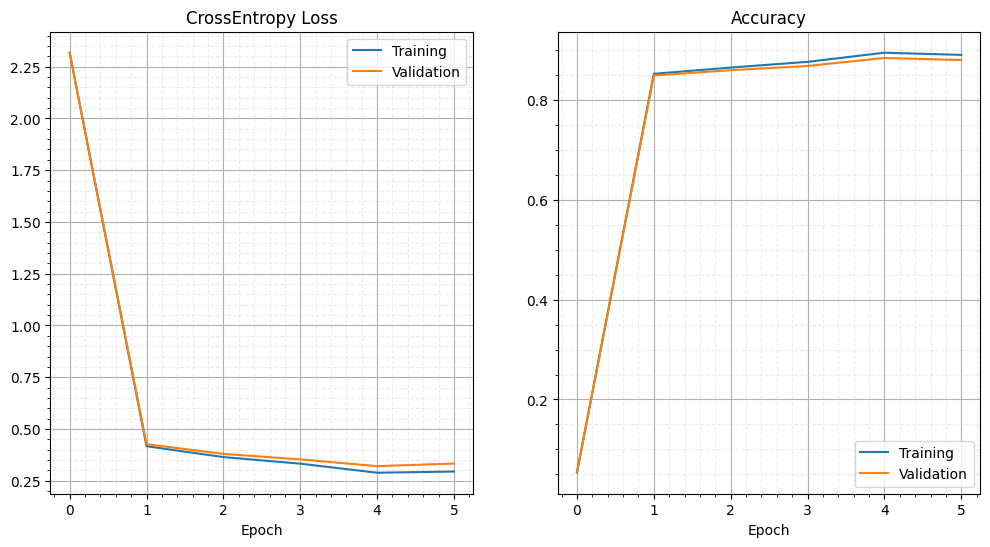

In [ ]:
# SGD
# Montrez les résultats pour la meilleure configuration trouvez ci-dessus.
depth = 3         # TODO: Vous devez modifier cette valeur avec la meilleur que vous avez eu.
width = 1000      # TODO: Vous devez modifier cette valeur avec la meilleur que vous avez eu.
lr = 0.001        # Some value
batch_size = 20   # Some value

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
  best_model, best_val_accuracy, logger = train(MLP_model,lr=lr, nb_epochs=5, sgd=True,
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Adam: Recherche d'hyperparamètres

Implémentez Adam, répétez les deux étapes précédentes (recherche d'hyperparamètres et analyse du meilleur modèle) cette fois en utilisat Adam, et comparez les performances finales avec votre meilleur modèle SGD.

In [ ]:
# ADAM
# Montrez les résultats pour différents nombre de couche, e.g. 1, 3, 5, et différent nombres de neurone, e.g. 25, 100, 300, 500, 1000.
depth_list = [1,3,5]                  # Define ranges in a list
width_list = [25,100,300,500,1000]    # Define ranges in a list
lr = 0.001                            # Some value
batch_size = 20                       # Some value

with torch.no_grad():
  for depth in depth_list:
    for width in width_list:
      print("------------------------------------------------------------------")
      print("Training model with a depth of {0} layers and a width of {1} units".format(depth, width))
      data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

      MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
      _, val_accuracy, _ = train(MLP_model, lr=lr, nb_epochs=5, sgd=False, data_loader_train=data_loader_train, data_loader_val=data_loader_val)
      print(f"validation accuracy = {val_accuracy*100:.3f}")

------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 25 units
Epoch  0,                 Train:loss=2.454, accuracy=10.1%,                 Valid: loss=2.452, accuracy=9.9%
Epoch  1,                 Train:loss=0.423, accuracy=85.4%,                 Valid: loss=0.436, accuracy=84.6%
Epoch  2,                 Train:loss=0.441, accuracy=84.0%,                 Valid: loss=0.463, accuracy=82.7%
Epoch  3,                 Train:loss=0.353, accuracy=87.6%,                 Valid: loss=0.386, accuracy=86.3%
Epoch  4,                 Train:loss=0.349, accuracy=87.3%,                 Valid: loss=0.384, accuracy=85.8%
Epoch  5,                 Train:loss=0.321, accuracy=88.4%,                 Valid: loss=0.355, accuracy=86.8%
validation accuracy = 86.817
------------------------------------------------------------------
Training model with a depth of 1 layers and a width of 100 units
Epoch  0,                 Train:loss=2.506, accur

#### **Tableau pour la précision sur l'ensemble de validation**
N.B. que les lignes correspondent aux nombre de couche et les colonnes correspondent au nombre de neurone dans chaque couche. Les valeurs ci-dessous sont donné comme exemples; remplacez-les par les valeurs que vous avez utilisées pour votre recherche d'hyperparamètres.

depth\width  | 25 | 100 | 300 | 500 | 1000
-------------------|------------------|------------------|------------------|------------------|------------------|
**1**   | 86.817  | 87.483 | 89.367 | 87.483 | 88.267 |
**3** | 87.265  | 87.583 | 87.850 | 88.233 | 88.000 |
**5**  | 86.217  | 87.700 | 87.517 | 87.550 | 87.250 |

### Adam: Analyse du meilleur modèle

Epoch  0,                 Train:loss=2.355, accuracy=8.6%,                 Valid: loss=2.351, accuracy=9.3%
Epoch  1,                 Train:loss=0.387, accuracy=85.8%,                 Valid: loss=0.418, accuracy=84.8%
Epoch  2,                 Train:loss=0.331, accuracy=87.7%,                 Valid: loss=0.376, accuracy=86.7%
Epoch  3,                 Train:loss=0.317, accuracy=88.3%,                 Valid: loss=0.378, accuracy=86.8%
Epoch  4,                 Train:loss=0.317, accuracy=87.7%,                 Valid: loss=0.392, accuracy=85.8%
Epoch  5,                 Train:loss=0.302, accuracy=88.9%,                 Valid: loss=0.389, accuracy=86.5%
Best validation accuracy = 86.767
Evaluation of the best training model over test set
------
Loss : 0.401
Accuracy : 86.410


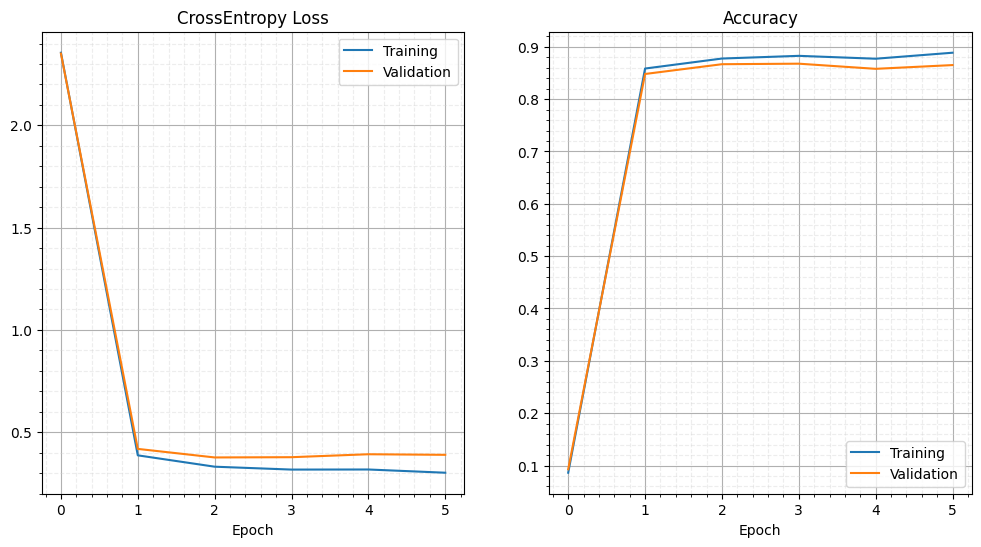

In [ ]:
# ADAM
# Montrez les résultats pour la meilleure configuration trouvez ci-dessus.
depth = 1             # TODO: Vous devez modifier cette valeur avec la meilleur que vous avez eu.
width = 300           # TODO: Vous devez modifier cette valeur avec la meilleur que vous avez eu.
lr = 0.001            # Some value
batch_size = 20       # Some value

with torch.no_grad():
  data_loader_train, data_loader_val, data_loader_test = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)

  MLP_model = MLPModel(n_features=784, n_hidden_features=width, n_hidden_layers=depth, n_classes=10)
  best_model, best_val_accuracy, logger = train(MLP_model,lr=lr, nb_epochs=5, sgd=False,
                                                data_loader_train=data_loader_train, data_loader_val=data_loader_val)
  logger.plot_loss_and_accuracy()
  print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

  accuracy_test, loss_test = accuracy_and_loss_whole_dataset(data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

### Implémentation en utilisant les capacités de Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_hidden_layers=3, num_classes=10):
        super(MLP, self).__init__()

        layers = []

        # Couche d'entrée
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Couches cachées
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Couche de sortie (Softmax directement dans Cross Entropy)
        layers.append(nn.Linear(hidden_size, num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return accuracy, loss

In [ ]:
def train_model(model, lr=0.1, nb_epochs=10, sgd=True, data_loader_train=None, data_loader_val=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Cross Entropy
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr) if sgd else optim.Adam(model.parameters(), lr=lr)

    best_model = None
    best_val_accuracy = 0

    for epoch in range(nb_epochs + 1):

        # Arbitrairement zero pour des raisons de simplicité pour l'epoch 0
        loss_train = 0.0
        accuracy_train = 0.0

        if epoch > 0:
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in data_loader_train:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Reset des gradients
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()  # Calcul automatique du gradient
                optimizer.step()  # Mise à jour des poids

                # Pour le calcul de l'accuracy
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Évaluation sur l'ensemble d'entrainement
            accuracy_train = 100. * correct / total
            loss_train = running_loss / len(data_loader_train)

        # Évaluation sur l'ensemble de validation
        accuracy_val, loss_val = evaluate_model(model, data_loader_val, criterion, device)

        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_model = model

        print(f"Epoch {epoch:2d}, "
              f"Train: loss={loss_train:.3f}, accuracy={accuracy_train:.1f}%, "
              f"Valid: loss={loss_val:.3f}, accuracy={accuracy_val:.1f}%")

    return best_model, best_val_accuracy

### Test sans Adam avec les paramètres optimaux trouvés

In [ ]:
depth_list = [3]
width_list = [1000]
lr = 0.001
batch_size = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for depth in depth_list:
    for width in width_list:
        print("------------------------------------------------------------------")
        print(f"Training model with {depth} hidden layers and {width} neurons per layer")

        train_loader, val_loader, test_loader = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
        model = MLP(input_size=784, hidden_size=width, num_hidden_layers=depth, num_classes=10).to(device)

        best_model, best_val_accuracy = train_model(model, lr=lr, nb_epochs=5, sgd=True, data_loader_train=train_loader, data_loader_val=val_loader)
        test_acc, test_loss = evaluate_model(best_model, test_loader, nn.CrossEntropyLoss(), device) # On calcule l'accuracy sur le jeu de test avec notre meilleur modèle

        print(f"Validation accuracy = {best_val_accuracy:.3f}")
        print(f"Test Accuracy = {test_acc:.2f}% | Test Loss = {test_loss:.4f}")


------------------------------------------------------------------
Training model with 3 hidden layers and 1000 neurons per layer


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  0, Train: loss=0.000, accuracy=0.0%, Valid: loss=2.303, accuracy=14.3%
Epoch  1, Train: loss=2.197, accuracy=30.5%, Valid: loss=1.999, accuracy=45.4%
Epoch  2, Train: loss=1.559, accuracy=55.2%, Valid: loss=1.197, accuracy=61.1%
Epoch  3, Train: loss=1.024, accuracy=64.3%, Valid: loss=0.900, accuracy=67.0%
Epoch  4, Train: loss=0.829, accuracy=69.4%, Valid: loss=0.781, accuracy=71.1%
Epoch  5, Train: loss=0.739, accuracy=72.7%, Valid: loss=0.713, accuracy=74.7%
Validation accuracy = 74.733
Test Accuracy = 73.59% | Test Loss = 0.7243


### Test sans Adam en augmentant le learning rate

In [ ]:
depth_list = [3]
width_list = [1000]
lr = 0.01
batch_size = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for depth in depth_list:
    for width in width_list:
        print("------------------------------------------------------------------")
        print(f"Training model with {depth} hidden layers and {width} neurons per layer")

        train_loader, val_loader, test_loader = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
        model = MLP(input_size=784, hidden_size=width, num_hidden_layers=depth, num_classes=10).to(device)

        best_model, best_val_accuracy = train_model(model, lr=lr, nb_epochs=5, sgd=True, data_loader_train=train_loader, data_loader_val=val_loader)
        test_acc, test_loss = evaluate_model(best_model, test_loader, nn.CrossEntropyLoss(), device) # On calcule l'accuracy sur le jeu de test avec notre meilleur modèle

        print(f"Validation accuracy = {best_val_accuracy:.3f}")
        print(f"Test Accuracy = {test_acc:.2f}% | Test Loss = {test_loss:.4f}")


------------------------------------------------------------------
Training model with 3 hidden layers and 1000 neurons per layer
Epoch  0, Train: loss=0.000, accuracy=0.0%, Valid: loss=2.302, accuracy=11.8%
Epoch  1, Train: loss=0.993, accuracy=66.3%, Valid: loss=0.586, accuracy=79.4%
Epoch  2, Train: loss=0.526, accuracy=81.5%, Valid: loss=0.473, accuracy=83.8%
Epoch  3, Train: loss=0.454, accuracy=83.9%, Valid: loss=0.426, accuracy=84.9%
Epoch  4, Train: loss=0.414, accuracy=85.2%, Valid: loss=0.436, accuracy=84.7%
Epoch  5, Train: loss=0.387, accuracy=86.3%, Valid: loss=0.391, accuracy=85.7%
Validation accuracy = 85.650
Test Accuracy = 84.92% | Test Loss = 0.4139


### Test avec Adam avec les paramètres optimaux trouvés

In [ ]:
depth_list = [1]
width_list = [300]
lr = 0.001
batch_size = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for depth in depth_list:
    for width in width_list:
        print("------------------------------------------------------------------")
        print(f"Training model with {depth} hidden layers and {width} neurons per layer")

        train_loader, val_loader, test_loader = get_fashion_mnist_dataloaders(val_percentage=0.1, batch_size=batch_size)
        model = MLP(input_size=784, hidden_size=width, num_hidden_layers=depth, num_classes=10).to(device)

        best_model, best_val_accuracy = train_model(model, lr=lr, nb_epochs=5, sgd=False, data_loader_train=train_loader, data_loader_val=val_loader)
        test_acc, test_loss = evaluate_model(best_model, test_loader, nn.CrossEntropyLoss(), device) # On calcule l'accuracy sur le jeu de test avec notre meilleur modèle

        print(f"Validation accuracy = {best_val_accuracy:.3f}")
        print(f"Test Accuracy = {test_acc:.2f}% | Test Loss = {test_loss:.4f}")

------------------------------------------------------------------
Training model with 1 hidden layers and 300 neurons per layer
Epoch  0, Train: loss=0.000, accuracy=0.0%, Valid: loss=2.298, accuracy=12.9%
Epoch  1, Train: loss=0.494, accuracy=82.3%, Valid: loss=0.359, accuracy=87.0%
Epoch  2, Train: loss=0.370, accuracy=86.5%, Valid: loss=0.332, accuracy=87.9%
Epoch  3, Train: loss=0.329, accuracy=87.9%, Valid: loss=0.315, accuracy=88.8%
Epoch  4, Train: loss=0.306, accuracy=88.8%, Valid: loss=0.321, accuracy=88.3%
Epoch  5, Train: loss=0.286, accuracy=89.5%, Valid: loss=0.300, accuracy=89.1%
Validation accuracy = 89.100
Test Accuracy = 88.08% | Test Loss = 0.3441


## Analyse des résultats


On peut faire plusieurs remarques sur nos résultats :  

•L'implémentation du MLP en partie 3 offre une précision supérieure au modèle simple implémenté en partie 2, atteignant généralement plus 85% de précision en validation contre ~80-85% pour l'ancien modèle.  
On pourrait expliquer cela à la capacité du MLP à capturer des relations non linéaires grâce à ses couches cachées.

•L'implémentation qui utilise les capacités de Pytorch semble donner des performances relativements similaires, voir meilleures (obtention du meilleur score 89%).  
L'exécution est aussi plus rapide, probablement due à des mécanismes internes d'optimisation.  
Par ailleurs, nous avons remarqué que les paramètres optimaux n'était pas forcément similaires à ceux trouvés lors de l'implémentation du MLP "à la main" (que 75% de précision contre 88% en utilisant les paramètres optimaux sans Adam).   
Nous avons alors vu qu'augmenter le learning rate pouvait alors augmenter cette précision assez basse.  
On pourrait attribuer cela au fait que l'implémentation avec la différenciation automatique diverge probablement dans l'initialisation des poids, la gestion des biais, ou encore lors du calcul des gradients (ajout de régularization)...

•L'implémentation avec Adam parait fournir de meilleures performances et converger plus rapidement, comme dans la partie 2.